# Web Scrapping
*[Cyril Pecoraro](http://github.com/cyril-p)*

**Scrapping Data from the Web**

In this project we will extract interesting information from IS-Academia, the educational portal of EPFL. Specifically, we will focus on the part that allows public access to academic [data](http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm?ww_i_reportmodel=133685247). 


We will obtain all the data for the "informatique" Bachelor students, starting from 2007. We will keep only the students for which we have an entry for both Bachelor semestre 1 and Bachelor semestre 6. We will compute how many months it took each student to go from the first to the sixth semester. We will partition the data between male and female students, and compute the average and find if the difference in average is statistically significant?

In [1]:
import requests 
import pandas as pd
from scipy import stats
% matplotlib inline
from bs4 import BeautifulSoup
import numpy as np



We have a BaseFormUrl, and from there, we will get the tags for the type of results, and every choice in the menu on the left of the page.

The idea is to hardcode the name of the parameters and get their possible values. 
Parameters are : 
'ww_i_reportModelXsl','ww_x_UNITE_ACAD','ww_x_PERIODE_ACAD','ww_x_PERIODE_PEDAGO','ww_x_HIVERETE'

In [2]:
# We define two url: One for selecting the parameters, one for displaying the student names.
baseFormUrl = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247'
baseFormUrlDisplay = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.bhtml?ww_b_list=1&ww_i_reportmodel=133685247'

r = requests.get(baseFormUrl)
soup = BeautifulSoup(r.content, "html.parser")

The idea is to put all the params needed and their possible values in a nested dictionary named 'ww_params'

Select the format of the page in table which has tag 'format'. Data is available in html or XLS. We use Html.

In [3]:
ww_params = dict()
formatTable = soup.find('table',attrs={'id': 'format'})
try:
    value = formatTable.findAll('input', attrs={'name':"ww_i_reportModelXsl"})
except:
    pass
value_ww_i_reportModelXsl = value[0]['value']
ww_params["ww_i_reportModelXsl"] = value_ww_i_reportModelXsl

We get the possible values for the parameters 'ww_i_reportModelXsl','ww_x_UNITE_ACAD','ww_x_PERIODE_ACAD','ww_x_PERIODE_PEDAGO','ww_x_HIVERETE'.

In [4]:
filtreName = ['ww_x_UNITE_ACAD','ww_x_PERIODE_ACAD','ww_x_PERIODE_PEDAGO','ww_x_HIVERETE']
filtreTable = soup.find('table',attrs={'id': 'filtre'})

for name in filtreName:
    ww_paramsList = dict()
    academicChoice = filtreTable.find('select',attrs={'name': name})
    value_ww_x_UNITE_ACAD = []
    try:
        choice = academicChoice.findAll('option')
    except:
        print('error')
        pass
    for option in choice:
        if (option['value']) != 'null':
            ww_paramsList[option.text]=option['value']
    ww_params[name] = ww_paramsList

Now we load the data by building a custom URL.  We first need to select the IS-Academia code for the parameters Bachelor 1 and Bachelor 6, fall semester and Spring semester, HTML Result, Informatique section

In [5]:
#Load the IS-academia code for html results and return error if there is a problem
htmlResult = ww_params.get('ww_i_reportModelXsl', 'error')

#Load the IS-academia code for fall semester and return error if there is a problem
fallSemester = ww_params.get('ww_x_HIVERETE').get('Semestre d\'automne', 'error')

#Load the IS-academia code for fall semester and return error if there is a problem
springSemester = ww_params.get('ww_x_HIVERETE').get('Semestre de printemps', 'error')

#Load the IS-academia code for bachelor 1 and return error if there is a problem
bachelor1 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Bachelor semestre 1', 'error')

#Load the IS-academia code for bachelor 6 and return error if there is a problem
bachelor6 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Bachelor semestre 6', 'error')

#Load the IS-academia code for Informatique and return error if there is a problem
informatique = ww_params.get('ww_x_UNITE_ACAD').get('Informatique', 'error')

But before getting the list of the student, we need to have another parameter "ww_x_GPS". 
2 calls will be made. The first one  will allow to obtain the ww_x_GPS, and the second one to load the students, using that ww_x_GPS.

Sometimes ww_x_GPS is not available, in this case, nothing will be done.

This solution is very very slow (but works).

In [6]:
#DataFrame of bachelor1 students. We already know the names of the columns
bachelor1DataFrame = pd.DataFrame(columns=('sex','name','sciper','year'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    ###First Call
    #Build the url:
    url = baseFormUrl + '&ww_b_list=1' + \
    '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
    '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
    '&ww_x_PERIODE_PEDAGO=' + bachelor1+ \
    '&ww_x_HIVERETE=' + fallSemester

    #Make a request
    r = requests.get(url)

    #Parse the URL with beautifulSoup
    soup = BeautifulSoup(r.content, "html.parser")

    #find the parameter ww_x_GPS (if it exists).
    try:
        value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
        #The value of ww_x_GPS is an argument of a javascript function. To islate it, we need to find it, then find the value.
        #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
        for val in value:
            #We are only interested in the value that is not -1
            if val['onclick'] != -1:
                position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                position_ww_x_GPS_end = substringBeginning.find('\'')
                ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
        ###Second call
        #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
        #Here the base Url changes because we display names.
        url = baseFormUrlDisplay + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + bachelor1+ \
        '&ww_x_HIVERETE=' + fallSemester + \
        '&ww_x_GPS=' + ww_x_GPS
         #Make a request
        r = requests.get(url)
        #Parse the page with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        my_table = soup.find('table')
        rows = my_table.findChildren(['th', 'tr'])
        
        for row in rows:
            cells = row.findChildren('td')
            #We already know the format of the data so we can simply select the desired columns
            if len(cells) == 12:
                sex = cells[0].find(text=True)
                name = cells[1].find(text=True)
                sciper = cells[10].find(text=True)
                #Let's keep only the first year of the string year. The year is given in the form 20XX-20XY. 
                #We will keep 20XX
                year = year[:4]
                
                s = pd.Series([sex,name,sciper,year],index=['sex','name','sciper','year'])
                bachelor1DataFrame = bachelor1DataFrame.append(s, ignore_index=True)

    except:
        pass

bachelor1DataFrame.head(10)

,sex,name,sciper,year
0,Monsieur,Ahluwalia Samit,184228,2008
1,Monsieur,Amiet Nils,179383,2008
2,Monsieur,Andenmatten Alexandre,186836,2008
3,Monsieur,Arnfred Jonas,184772,2008
4,Monsieur,Badila Constantin-Tudor,187235,2008
5,Monsieur,Bougacha Malik,186264,2008
6,Monsieur,Bourgeois Jérémy,185949,2008
7,Monsieur,Bourqui Marc,184264,2008
8,Monsieur,Bruchez Lionel,186825,2008
9,Monsieur,Bullot Marc,186009,2008


In [7]:
#DataFrame of bachelor6 students. We already know the names of the columns
bachelor6DataFrame = pd.DataFrame(columns=('sex','name','sciper','year'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    ###First Call
    #Build the url:
    url = baseFormUrl + '&ww_b_list=1' + \
    '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
    '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
    '&ww_x_PERIODE_PEDAGO=' + bachelor6+ \
    '&ww_x_HIVERETE=' + springSemester

    #Make a request
    r = requests.get(url)

    #Parse the URL with beautifulSoup
    soup = BeautifulSoup(r.content, "html.parser")

    #find the parameter ww_x_GPS (if it exists).
    try:
        value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
        #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
        #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
        for val in value:
            #We are only interested in the value that is not -1
            if val['onclick'] != -1:
                position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                position_ww_x_GPS_end = substringBeginning.find('\'')
                ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
        ###Second call
        #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
        #Here the base Url changes because we display names.
        url = baseFormUrlDisplay + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + bachelor6+ \
        '&ww_x_HIVERETE=' + springSemester + \
        '&ww_x_GPS=' + ww_x_GPS
         #Make a request
        r = requests.get(url)
        #Parse the page with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        my_table = soup.find('table')
        rows = my_table.findChildren(['th', 'tr'])
        
        for row in rows:
            cells = row.findChildren('td')
            #We already know the format of the data so we can simply select the desired columns
            if len(cells) == 12:
                sex = cells[0].find(text=True)
                name = cells[1].find(text=True)
                sciper = cells[10].find(text=True)
                #Let's keep only the first year of the string year. The year is given in the form 20XX-20XY. 
                #We will keep 20XX
                year = year[:4]
                s = pd.Series([sex,name,sciper,year],index=['sex','name','sciper','year'])
                bachelor6DataFrame = bachelor6DataFrame.append(s, ignore_index=True)

    except:
        pass

bachelor6DataFrame.head(10)

,sex,name,sciper,year
0,Monsieur,Balas Martin,174774,2008
1,Monsieur,Barras Florian,170220,2008
2,Monsieur,Beuret Thibaut,166701,2008
3,Monsieur,Bindschaedler Laurent,170654,2008
4,Monsieur,Biollay Jean Isaac Jamal Pachacutec,161279,2008
5,Monsieur,Blanc Régis William,175339,2008
6,Monsieur,Blatter Jérémy,166344,2008
7,Monsieur,Brunet Yorick,178283,2008
8,Monsieur,Burgener Raphaël,170225,2008
9,Monsieur,Candemir Mehmet,161814,2008


## Data cleaning

We can see that some students are present several times. Some students have done bachelor 6 twice or more. We will keep only the latest year.

In [8]:
c_maxs = bachelor6DataFrame.groupby('sciper').year.transform(max)
bachelor6DataFrame = bachelor6DataFrame[bachelor6DataFrame.year == c_maxs]

Similarly, there are duplicates in the bachelor1 DataFrame. Some students have done bachelor 1 twice. 
We will keep only the earliest date, as it is the first time they were in Bachelor1

In [9]:
c_mins = bachelor1DataFrame.groupby('sciper').year.transform(min)
bachelor1DataFrame = bachelor1DataFrame[bachelor1DataFrame.year == c_mins]

### Merge DataFrames 
keep students that are present only in both dataFrames. This is an inner joint of the 2 dataframes

In [10]:
bachelorStudentsDataFrame = pd.merge(bachelor1DataFrame, bachelor6DataFrame, how='inner', on=['sex', 'name', 'sciper'], suffixes=('_bachelor1', '_bachelor6'))
bachelorStudentsDataFrame.head(10)

,sex,name,sciper,year_bachelor1,year_bachelor6
0,Monsieur,Arnfred Jonas,184772,2008,2010
1,Monsieur,Bougacha Malik,186264,2008,2012
2,Monsieur,Bourgeois Jérémy,185949,2008,2010
3,Monsieur,Bourqui Marc,184264,2008,2012
4,Monsieur,Bruchez Lionel,186825,2008,2010
5,Monsieur,Chablais Michael,184991,2008,2010
6,Monsieur,Constantin Victor,185283,2008,2012
7,Monsieur,Cressier Gilles,178287,2008,2010
8,Monsieur,Cuony Maximilien,185952,2008,2010
9,Monsieur,Droxler Thomas,185959,2008,2011


We put the types of the sciper and years as int.

In [11]:
bachelorStudentsDataFrame[['sciper','year_bachelor6', 'year_bachelor1']] = bachelorStudentsDataFrame[['sciper','year_bachelor6', 'year_bachelor1']].astype(int)

There are no more duplicates in the complete bachelorStudentsDataFrame.

In [12]:
bachelorStudentsDataFrame.duplicated('sciper').sum()

0

### Number of months
There are 10 months between september and July for 1 year. Let's compute the number of month needed for each student to go from bachelor 1 to bachelor 6.

In [13]:
def number_months(x): 
    return (x['year_bachelor6']-x['year_bachelor1'])*12 + 10

bachelorStudentsDataFrame['number_months'] = bachelorStudentsDataFrame.apply(number_months, axis = 1) 

In [14]:
bachelorStudentsDataFrame.sort_values('name').head(10)

,sex,name,sciper,year_bachelor1,year_bachelor6,number_months
376,Monsieur,Abate Bryan Jeremy,246671,2014,2016,34
88,Monsieur,Aiulfi Loris Sandro,202293,2010,2015,70
377,Monsieur,Alami-Idrissi Ali,251759,2014,2016,34
145,Monsieur,Alfonso Peterssen Alfonso,228219,2013,2015,34
192,Monsieur,Alonso Seisdedos Florian,215576,2011,2015,58
193,Monsieur,Amorim Afonso Caldeira Da Silva Pedro Maria,213618,2011,2014,46
194,Monsieur,Andreina Sébastien Laurent,215623,2011,2014,46
89,Monsieur,Angel Axel,201284,2010,2012,34
195,Monsieur,Angerand Grégoire Georges Jacques,212464,2011,2015,58
43,Monsieur,Antognini Marco,194182,2009,2012,46


### Partition in male/female
we will construct two dataFrames, one for females, the other for males.

In [15]:
bachelorFemaleStudentsDataFrame = bachelorStudentsDataFrame[bachelorStudentsDataFrame['sex'] == 'Madame']
bachelorMaleStudentsDataFrame = bachelorStudentsDataFrame[bachelorStudentsDataFrame['sex']=='Monsieur']

Number of female students:

In [16]:
bachelorFemaleStudentsDataFrame['sciper'].count()

29

Number of female students:

In [17]:
bachelorMaleStudentsDataFrame['sciper'].count()

368

## Data analysis
The main quesiton is : "For the number of months between bachelor 1 and 6, is the difference in average statistically significant between male and female students?"

First let's have a look at the data


We can see that most of the female students completed their bachelor in 2 years, and a few did it in 3 years.

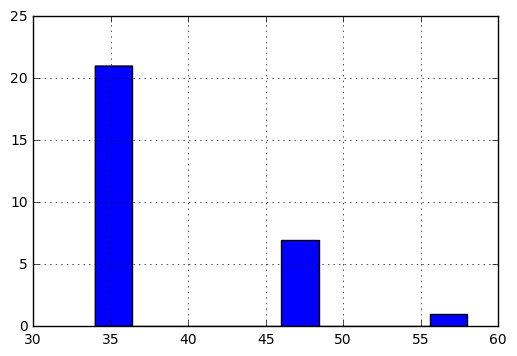

In [18]:
bachelorFemaleStudentsDataFrame['number_months'].hist()

**The mean is at 37.72 months**

In [19]:
bachelorFemaleStudentsDataFrame['number_months'].describe()

count    29.000000
mean     37.724138
std       6.496684
min      34.000000
25%      34.000000
50%      34.000000
75%      46.000000
max      58.000000
Name: number_months, dtype: float64

We can see that most of the male students completed their bachelor in 2 years, and a few did it in 3 years, and some in 70 months.

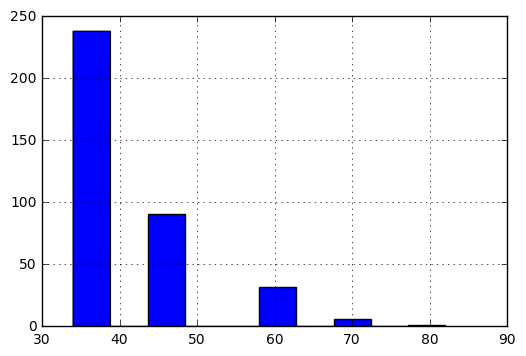

In [20]:
bachelorMaleStudentsDataFrame['number_months'].hist()

**The mean is at 39.77**

In [21]:
bachelorMaleStudentsDataFrame['number_months'].describe()

count    368.000000
mean      39.771739
std        8.943788
min       34.000000
25%       34.000000
50%       34.000000
75%       46.000000
max       82.000000
Name: number_months, dtype: float64

In [22]:
bachelorMaleStudentsDataFrame.loc[bachelorMaleStudentsDataFrame['number_months']==82]

,sex,name,sciper,year_bachelor1,year_bachelor6,number_months
72,Monsieur,Perrin Sami,196034,2009,2015,82


### Statistical tests
"For the number of months between bachelor 1 and 6, is the difference in average statistically significant between male and female students?"

We will perform a Welch’s t-test, because the variance, mean and sample size are different. 
See doc of the function used [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)


H0: "Both population have equal mean"
H1: "The means are different"

In [23]:
stats.ttest_ind(bachelorMaleStudentsDataFrame['number_months'], bachelorFemaleStudentsDataFrame['number_months'], equal_var = False)

Ttest_indResult(statistic=1.5831651359439409, pvalue=0.12191236829650401)

With a p-value that is above 0.05 and t-statistic < 1,95, we can not reject H0. 

**Conclusion : there is no significant in the difference in average between male and female students**

# Question 2 - Master Student

### Building dataframes

Defining is-academia code for Master 1, Master 2, Master 3 and Master thesis

In [24]:
#Load the IS-academia code for Master 1 and return error if there is a problem
master1 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Master semestre 1', 'error')

#Load the IS-academia code for Master 2 and return error if there is a problem
master2 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Master semestre 2', 'error')

#Load the IS-academia code for Master 3 and return error if there is a problem
master3 = ww_params.get('ww_x_PERIODE_PEDAGO').get('Master semestre 3', 'error')

#Load the IS-academia code for Projet master automne and return error if there is a problem
pdm_a = ww_params.get('ww_x_PERIODE_PEDAGO').get('Projet Master automne', 'error')

#Load the IS-academia code for Projet master printemps and return error if there is a problem
pdm_p = ww_params.get('ww_x_PERIODE_PEDAGO').get('Projet Master printemps', 'error')

pdm= [pdm_a, pdm_p] # We get the two codes for Master thesis into one variable


DataFrame for students enrolled in Master 1 

In [25]:
#DataFrame of Master 1 students. We already know the names of the columns
master1DataFrame = pd.DataFrame(columns=('sex','name','sciper','year','specialisation', 'mineur'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    for semester in ww_params.get('ww_x_HIVERETE'):
        ###First Call
        #Build the url:
        url = baseFormUrl + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + master1+ \
        '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester)

        #Make a request
        r = requests.get(url)

        #Parse the URL with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        #find the parameter ww_x_GPS (if it exists).
        try:
            value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
            #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
            #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
            for val in value:
                #We are only interested in the value that is not -1
                if val['onclick'] != -1:
                    position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                    substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                    position_ww_x_GPS_end = substringBeginning.find('\'')
                    ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
            ###Second call
            #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
            #Here the base Url changes because we display names.
            url = baseFormUrlDisplay + '&ww_b_list=1' + \
            '&ww_i_reportModelXsl=' + htmlResult + \
            '&ww_x_UNITE_ACAD=' + informatique + \
            '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
            '&ww_x_PERIODE_PEDAGO=' + master1+ \
            '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester) + \
            '&ww_x_GPS=' + ww_x_GPS
             #Make a request
            r = requests.get(url)
            #Parse the page with beautifulSoup
            soup = BeautifulSoup(r.content, "html.parser")

            my_table = soup.find('table')
            rows = my_table.findChildren(['th', 'tr'])
        
            for row in rows:
                cells = row.findChildren('td')
                #We already know the format of the data so we can simply select the desired columns
                if len(cells) == 12:
                    sex = cells[0].find(text=True)
                    name = cells[1].find(text=True)
                    specialisation = cells[4].find(text=True)
                    mineur = cells[6].find(text=True)
                    sciper = cells[10].find(text=True)
                    #The year will be defined such as 2014 if it is spring semester in 2014
                    #and 2014.5 if it is automn semester in 2014
                    if semester=='Semestre d\'automne':
                        annee = float(year[:4])+0.5 
                    else:
                        annee=float(year[5:])
                    s = pd.Series([sex,name,sciper,annee,specialisation,mineur],index=['sex','name','sciper','year', 'specialisation', 'mineur'])
                    master1DataFrame = master1DataFrame.append(s, ignore_index=True)

        except:
            pass

master1DataFrame.head(10)

,sex,name,sciper,year,specialisation,mineur
0,Madame,Aydin Ebru,183512,2008.5,None,None
1,Monsieur,Bakshev Stanimir,185607,2008.5,None,None
2,Monsieur,Bécholey Alexandre,160213,2008.5,None,None
3,Monsieur,Blanvillain Christian,184737,2008.5,None,None
4,Monsieur,Boksanyi Michael,161634,2008.5,None,None
5,Monsieur,Bolkensteyn Dinesh,170451,2008.5,None,None
6,Monsieur,Bonnet Rémi,183895,2008.5,Foundations of Software,None
7,Monsieur,Bornet Cyril Antoine Michel,170219,2008.5,None,None
8,Monsieur,Bouaziz Sofien,179749,2008.5,None,None
9,Monsieur,Cassina Ilya,153746,2008.5,None,None


Building dataframe Master 2

In [26]:

#DataFrame of Master 2 students. We already know the names of the columns
master2DataFrame = pd.DataFrame(columns=('sex','name','sciper','year','specialisation', 'mineur'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    for semester in ww_params.get('ww_x_HIVERETE'):
        ###First Call
        #Build the url:
        url = baseFormUrl + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + master2+ \
        '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester)

        #Make a request
        r = requests.get(url)

        #Parse the URL with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        #find the parameter ww_x_GPS (if it exists).
        try:
            value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
            #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
            #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
            for val in value:
                #We are only interested in the value that is not -1
                if val['onclick'] != -1:
                    position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                    substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                    position_ww_x_GPS_end = substringBeginning.find('\'')
                    ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
            ###Second call
            #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
            #Here the base Url changes because we display names.
            url = baseFormUrlDisplay + '&ww_b_list=1' + \
            '&ww_i_reportModelXsl=' + htmlResult + \
            '&ww_x_UNITE_ACAD=' + informatique + \
            '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
            '&ww_x_PERIODE_PEDAGO=' + master2+ \
            '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester) + \
            '&ww_x_GPS=' + ww_x_GPS
             #Make a request
            r = requests.get(url)
            #Parse the page with beautifulSoup
            soup = BeautifulSoup(r.content, "html.parser")

            my_table = soup.find('table')
            rows = my_table.findChildren(['th', 'tr'])
        
            for row in rows:
                cells = row.findChildren('td')
                #We already know the format of the data so we can simply select the desired columns
                if len(cells) == 12:
                    sex = cells[0].find(text=True)
                    name = cells[1].find(text=True)
                    specialisation = cells[4].find(text=True)
                    mineur = cells[6].find(text=True)
                    sciper = cells[10].find(text=True)
                    #The year will be defined such as 2014 if it is spring semester in 2014
                    #and 2014.5 if it is automn semester in 2014
                    if semester=='Semestre d\'automne':
                        annee = float(year[:4])+0.5
                    else:
                        annee=float(year[5:])
                    s = pd.Series([sex,name,sciper,annee,specialisation,mineur],index=['sex','name','sciper','year', 'specialisation', 'mineur'])
                    master2DataFrame = master2DataFrame.append(s, ignore_index=True)

        except:
            pass

master2DataFrame.head(10)

,sex,name,sciper,year,specialisation,mineur
0,Monsieur,Aeberhard François-Xavier,153066,2009.0,None,None
1,Madame,Aydin Ebru,183512,2009.0,None,None
2,Monsieur,Bakshev Stanimir,185607,2009.0,None,None
3,Monsieur,Bécholey Alexandre,160213,2009.0,None,None
4,Madame,Benabdallah Zeineb,154573,2009.0,Biocomputing,None
5,Monsieur,Blanvillain Christian,184737,2009.0,None,None
6,Monsieur,Boksanyi Michael,161634,2009.0,None,None
7,Monsieur,Bolkensteyn Dinesh,170451,2009.0,None,None
8,Monsieur,Bonnet Rémi,183895,2009.0,Foundations of Software,None
9,Monsieur,Bornet Cyril Antoine Michel,170219,2009.0,None,None


Let's now build the dataframe for Master 3 student

In [27]:

#DataFrame of Master 2 students. We already know the names of the columns
master3DataFrame = pd.DataFrame(columns=('sex','name','sciper','year','specialisation', 'mineur'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    for semester in ww_params.get('ww_x_HIVERETE'):
        ###First Call
        #Build the url:
        url = baseFormUrl + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + master3+ \
        '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester)

        #Make a request
        r = requests.get(url)

        #Parse the URL with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        #find the parameter ww_x_GPS (if it exists).
        try:
            value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
            #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
            #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
            for val in value:
                #We are only interested in the value that is not -1
                if val['onclick'] != -1:
                    position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                    substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                    position_ww_x_GPS_end = substringBeginning.find('\'')
                    ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
            ###Second call
            #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
            #Here the base Url changes because we display names.
            url = baseFormUrlDisplay + '&ww_b_list=1' + \
            '&ww_i_reportModelXsl=' + htmlResult + \
            '&ww_x_UNITE_ACAD=' + informatique + \
            '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
            '&ww_x_PERIODE_PEDAGO=' + master3+ \
            '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester) + \
            '&ww_x_GPS=' + ww_x_GPS
             #Make a request
            r = requests.get(url)
            #Parse the page with beautifulSoup
            soup = BeautifulSoup(r.content, "html.parser")

            my_table = soup.find('table')
            rows = my_table.findChildren(['th', 'tr'])
        
            for row in rows:
                cells = row.findChildren('td')
                #We already know the format of the data so we can simply select the desired columns
                if len(cells) == 12:
                    sex = cells[0].find(text=True)
                    name = cells[1].find(text=True)
                    specialisation = cells[4].find(text=True)
                    mineur = cells[6].find(text=True)
                    sciper = cells[10].find(text=True)
                    #The year will be defined such as 2014 if it is spring semester in 2014
                    #and 2014.5 if it is automn semester in 2014
                    if semester=='Semestre d\'automne':
                        annee = float(year[:4])+0.5
                    else:
                        annee=float(year[5:])
                    s = pd.Series([sex,name,sciper,annee,specialisation,mineur],index=['sex','name','sciper','year', 'specialisation', 'mineur'])
                    master3DataFrame = master3DataFrame.append(s, ignore_index=True)

        except:
            pass

master3DataFrame.head(10)

,sex,name,sciper,year,specialisation,mineur
0,Monsieur,Aeberhard François-Xavier,153066,2008.5,None,None
1,Monsieur,Anagnostaras David,152232,2008.5,None,"Mineur en Management, technologie et entrepren..."
2,Monsieur,Auroux Damien,177395,2008.5,Internet computing,None
3,Monsieur,Awalebo Joseph,161970,2008.5,None,None
4,Monsieur,Balet Ken,166258,2008.5,Internet computing,None
5,Monsieur,Bayramoglu Ersoy,178879,2008.5,None,None
6,Madame,Benabdallah Zeineb,154573,2008.5,Biocomputing,None
7,Monsieur,Billaud Joël,172687,2008.5,None,None
8,Monsieur,Brightwell Mark,179802,2008.5,None,None
9,Monsieur,Campora Simone,180072,2008.5,Internet computing,None


Let's now build the dataframe for Master thesis

We are gonna make a varibale for Master thesis Automn and Master thesis Spring. We will not save that information anywhere in the dataframe as we already have the information if it is in spring or automn by considering the year. 
2014-> spring semester 2014.5-> automn semester

In [28]:

#DataFrame of Master thesis students. We already know the names of the columns
pdmDataFrame = pd.DataFrame(columns=('sex','name','sciper','year','specialisation', 'mineur'))

for year in ww_params.get('ww_x_PERIODE_ACAD'):
    for semester in ww_params.get('ww_x_HIVERETE'):
        
        #If we are looking at the autmon semester we are gonna look for "Projet Master automne" and if we are
        #searching in spring we will look for "Projet Master printemps" for the period academic
        if semester=='Semestre d\'automne':
            project=pdm_a
        else:
            project=pdm_p
            
        ###First Call
        #Build the url:
        url = baseFormUrl + '&ww_b_list=1' + \
        '&ww_i_reportModelXsl=' + htmlResult + \
        '&ww_x_UNITE_ACAD=' + informatique + \
        '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
        '&ww_x_PERIODE_PEDAGO=' + project+ \
        '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester)

        #Make a request
        r = requests.get(url)

        #Parse the URL with beautifulSoup
        soup = BeautifulSoup(r.content, "html.parser")

        #find the parameter ww_x_GPS (if it exists).
        try:
            value = soup.findAll('a', attrs={'class':'ww_x_GPS'})
            #The value of ww_x_GPS is an argument of a javascript function. To isolate it, we need to find it, then find the value.
            #Substrings are used. First we find 'ww_x_GPS', then we find the next "'" so that we can keep the value only.
            for val in value:
                #We are only interested in the value that is not -1
                if val['onclick'] != -1:
                    position_ww_x_GPS_beginning = val['onclick'].find('ww_x_GPS')+len('ww_x_GPS')+1
                    substringBeginning = val['onclick'][position_ww_x_GPS_beginning:]
                    position_ww_x_GPS_end = substringBeginning.find('\'')
                    ww_x_GPS = substringBeginning[:position_ww_x_GPS_end]
            ###Second call
            #Now that we have the ww_x_GPS, we can make another call and obtain the list of the students.
            #Here the base Url changes because we display names.
            url = baseFormUrlDisplay + '&ww_b_list=1' + \
            '&ww_i_reportModelXsl=' + htmlResult + \
            '&ww_x_UNITE_ACAD=' + informatique + \
            '&ww_x_PERIODE_ACAD=' + ww_params.get('ww_x_PERIODE_ACAD').get(year) + \
            '&ww_x_PERIODE_PEDAGO=' + project+ \
            '&ww_x_HIVERETE=' + ww_params.get('ww_x_HIVERETE').get(semester) + \
            '&ww_x_GPS=' + ww_x_GPS
             #Make a request
            r = requests.get(url)
            #Parse the page with beautifulSoup
            soup = BeautifulSoup(r.content, "html.parser")

            my_table = soup.find('table')
            rows = my_table.findChildren(['th', 'tr'])
        
            for row in rows:
                cells = row.findChildren('td')
                #We already know the format of the data so we can simply select the desired columns
                if len(cells) == 12:
                    sex = cells[0].find(text=True)
                    name = cells[1].find(text=True)
                    specialisation = cells[4].find(text=True)
                    mineur = cells[6].find(text=True)
                    sciper = cells[10].find(text=True)
                    #The year will be defined such as 2014 if it is spring semester in 2014
                    #and 2014.5 if it is automn semester in 2014
                    if semester=='Semestre d\'automne':
                        annee = float(year[:4])+0.5
                    else:
                        annee=float(year[5:])
                    s = pd.Series([sex,name,sciper,annee,specialisation,mineur],index=['sex','name','sciper','year', 'specialisation', 'mineur'])
                    pdmDataFrame = pdmDataFrame.append(s, ignore_index=True)

        except:
            pass

pdmDataFrame.head(10)

,sex,name,sciper,year,specialisation,mineur
0,Madame,Agarwal Megha,180027,2008.5,None,None
1,Monsieur,Brutsche Florian,159852,2008.5,Internet computing,None
2,Monsieur,Fleury Marc-Olivier,166805,2008.5,None,None
3,Monsieur,Garg Nikhil,172264,2008.5,None,None
4,Monsieur,Billaud Joël,172687,2009.0,None,None
5,Monsieur,Campora Simone,180072,2009.0,Internet computing,None
6,Monsieur,Cassata Alexandre,160225,2009.0,None,None
7,Monsieur,Hofer Thomas,165819,2009.0,Foundations of Software,None
8,Monsieur,Muriel Hugo Marcelo,179878,2009.0,Internet computing,None
9,Monsieur,Ragnerstam Erik,177476,2009.0,None,None


### Merging dataframe

We gonna first handle duplicates. If a student is registered twice in Master 1 we will keep only the earliest. If a master is registered twice in master 2 we will keep the earliest and the latest if he's twice in master 3, or in master thesis we will keep the latest registration.

This is based on the assumption that a student can start his master either in Master 1 or in Master 2 and that he can finish his last semester of courses either in Master 2 or 3.

We also gonna replace all the None by Nan, as it is easier to handle

In [29]:
#Keeping the earliest registration for master 1
c_mins = master1DataFrame.groupby('sciper').year.transform(min)
master1DataFrame = master1DataFrame[master1DataFrame.year == c_mins]
master1DataFrame.fillna(value=np.nan, inplace=True)

#Keeping the earliest registration for master 2 
p_mins = master2DataFrame.groupby('sciper').year.transform(min)
master2DataFrame_e = master2DataFrame[master2DataFrame.year == p_mins]
master2DataFrame_e.fillna(value=np.nan, inplace=True)

#Keeping the latest registration for master 2 
c_maxs = master2DataFrame.groupby('sciper').year.transform(max)
master2DataFrame_l = master2DataFrame[master2DataFrame.year == c_maxs]
master2DataFrame_l.fillna(value=np.nan, inplace=True)


#Keeping the latest registration for master 3 
d_maxs = master3DataFrame.groupby('sciper').year.transform(max)
master3DataFrame = master3DataFrame[master3DataFrame.year == d_maxs]
master3DataFrame.fillna(value=np.nan, inplace=True)


#Keeping the latest registration for master thesis
p_maxs = pdmDataFrame.groupby('sciper').year.transform(max)
pdmDataFrame = pdmDataFrame[pdmDataFrame.year == p_maxs]
pdmDataFrame.fillna(value=np.nan, inplace=True)



/Users/Charlotte/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


We now gonna make an outer-join between master 1 and the earliest subscription in master 2. The results of that join will then be left join with the latest subscription in master 2. This enables us to keep both dates of registration to master 2 in the dataframe.

We assume that if someone is registered in a mineur or specialisation is registered in it in all his master semester so we also join on specialisation and mineur.

In [30]:
master1_2 = pd.merge(master1DataFrame, master2DataFrame_e, how='outer', on=['sex', 'name', 'sciper','mineur','specialisation'], suffixes=('_master1', '_master2_earliest'))
master1_2 = pd.merge(master1_2, master2DataFrame_l, how='left', on=['sex', 'name', 'sciper','mineur','specialisation'], suffixes=('_master1', '_master2'))
master1_2 = master1_2.rename(columns={'year': 'year_master2_latest'}) #Renaming column year that comes from dataframe master 3 to year_master 3

master1_2.tail(10)

,sex,name,sciper,year_master1,specialisation,mineur,year_master2_earliest,year_master2_latest
1103,Monsieur,Mouchet Christian Vincent,217453,NaN,NaN,Information security minor,2015.0,2016.0
1104,Madame,Nikitina Tatiana,245685,NaN,Internet computing,NaN,2015.0,2016.0
1105,Madame,Pignat Eliéva Arlette,217301,NaN,Computer Engineering - SP,NaN,2015.0,2016.0
1106,Monsieur,Renucci Allan Vincent Roger,205095,NaN,Foundations of Software,NaN,2015.0,NaN
1107,Monsieur,Roulin Andy,216690,NaN,Computer Engineering - SP,NaN,2015.0,2016.0
1108,Monsieur,Rudelle Matthieu François Edgard,216702,NaN,Internet computing,NaN,2015.0,2016.0
1109,Madame,Salathé Joanna Béatrice,217489,NaN,NaN,NaN,2015.0,NaN
1110,Monsieur,Sikiaridis Alexandre Jean Denis,217469,NaN,Foundations of Software,NaN,2015.0,2016.0
1111,Monsieur,Vostriakov Alexander,196683,NaN,NaN,Mineur en Neurosciences computationnelles,2015.0,2016.0
1112,Monsieur,Zimmermann Florian,170946,NaN,"Signals, Images and Interfaces",NaN,2015.0,2016.0


Now we gonna make a left_join with student registered in master 3. As all the students have not to be registered in master 3 to finish their master but have to be registered in master 1 or 2 before doing master 3, that is why a left_join has been chosen

In [31]:
master = pd.merge(master1_2, master3DataFrame, how='left', on=['sex', 'name', 'sciper','specialisation','mineur'], suffixes=('', '_master3'))
master = master.rename(columns={'year': 'year_master3'}) #Renaming column year that comes from dataframe master 3 to year_master 3
master.head(10)

,sex,name,sciper,year_master1,specialisation,mineur,year_master2_earliest,year_master2_latest,year_master3
0,Madame,Aydin Ebru,183512,2008.5,NaN,NaN,2009.0,2009.0,NaN
1,Monsieur,Bakshev Stanimir,185607,2008.5,NaN,NaN,2009.0,2009.0,NaN
2,Monsieur,Bécholey Alexandre,160213,2008.5,NaN,NaN,2008.0,2009.0,NaN
3,Monsieur,Blanvillain Christian,184737,2008.5,NaN,NaN,2009.0,2010.0,2009.5
4,Monsieur,Boksanyi Michael,161634,2008.5,NaN,NaN,2009.0,2009.0,NaN
5,Monsieur,Bolkensteyn Dinesh,170451,2008.5,NaN,NaN,2009.0,NaN,NaN
6,Monsieur,Bonnet Rémi,183895,2008.5,Foundations of Software,NaN,2009.0,2009.0,NaN
7,Monsieur,Bornet Cyril Antoine Michel,170219,2008.5,NaN,NaN,2009.0,2009.0,NaN
8,Monsieur,Bouaziz Sofien,179749,2008.5,NaN,NaN,NaN,NaN,NaN
9,Monsieur,Conus Johann,153762,2008.5,NaN,NaN,2009.0,2010.0,2009.5


Now we gonna make a left_join with student registered in master thesis.We will use a left_join as students have to 
first be registered in master 1 or 2 before doing a master thesis

In [32]:
master = pd.merge(master, pdmDataFrame, how='left', on=['sex', 'name', 'sciper','specialisation','mineur'], suffixes=('', 'pdm'))
master = master.rename(columns={'year': 'year_pdm'}) #Renaming column year that comes from dataframe master 3 to year_master 3
master.head(10)

,sex,name,sciper,year_master1,specialisation,mineur,year_master2_earliest,year_master2_latest,year_master3,year_pdm
0,Madame,Aydin Ebru,183512,2008.5,NaN,NaN,2009.0,2009.0,NaN,2009.5
1,Monsieur,Bakshev Stanimir,185607,2008.5,NaN,NaN,2009.0,2009.0,NaN,NaN
2,Monsieur,Bécholey Alexandre,160213,2008.5,NaN,NaN,2008.0,2009.0,NaN,2010.0
3,Monsieur,Blanvillain Christian,184737,2008.5,NaN,NaN,2009.0,2010.0,2009.5,NaN
4,Monsieur,Boksanyi Michael,161634,2008.5,NaN,NaN,2009.0,2009.0,NaN,NaN
5,Monsieur,Bolkensteyn Dinesh,170451,2008.5,NaN,NaN,2009.0,NaN,NaN,NaN
6,Monsieur,Bonnet Rémi,183895,2008.5,Foundations of Software,NaN,2009.0,2009.0,NaN,NaN
7,Monsieur,Bornet Cyril Antoine Michel,170219,2008.5,NaN,NaN,2009.0,2009.0,NaN,NaN
8,Monsieur,Bouaziz Sofien,179749,2008.5,NaN,NaN,NaN,NaN,NaN,NaN
9,Monsieur,Conus Johann,153762,2008.5,NaN,NaN,2009.0,2010.0,2009.5,NaN


### Computing time of stay

Now we gonna split the dataframe into 2, one with all the students that have a specialisation or a minor and one with 
student's that doesn't. 

In [33]:
#Students with no master and no specialization
students_no_s_m=master[pd.isnull(master['specialisation']) & pd.isnull(master['mineur'])]
students_no_s_m.head(10)

,sex,name,sciper,year_master1,specialisation,mineur,year_master2_earliest,year_master2_latest,year_master3,year_pdm
0,Madame,Aydin Ebru,183512,2008.5,NaN,NaN,2009.0,2009.0,NaN,2009.5
1,Monsieur,Bakshev Stanimir,185607,2008.5,NaN,NaN,2009.0,2009.0,NaN,NaN
2,Monsieur,Bécholey Alexandre,160213,2008.5,NaN,NaN,2008.0,2009.0,NaN,2010.0
3,Monsieur,Blanvillain Christian,184737,2008.5,NaN,NaN,2009.0,2010.0,2009.5,NaN
4,Monsieur,Boksanyi Michael,161634,2008.5,NaN,NaN,2009.0,2009.0,NaN,NaN
5,Monsieur,Bolkensteyn Dinesh,170451,2008.5,NaN,NaN,2009.0,NaN,NaN,NaN
7,Monsieur,Bornet Cyril Antoine Michel,170219,2008.5,NaN,NaN,2009.0,2009.0,NaN,NaN
8,Monsieur,Bouaziz Sofien,179749,2008.5,NaN,NaN,NaN,NaN,NaN,NaN
9,Monsieur,Conus Johann,153762,2008.5,NaN,NaN,2009.0,2010.0,2009.5,NaN
10,Monsieur,Crisan Daniel,183920,2008.5,NaN,NaN,2009.0,2009.0,NaN,NaN


We gonna remove students that have not done master 3 while having a spe or a minor

In [34]:
#Students with a minor or specialisation
students_s_m=master[~pd.isnull(master['specialisation']) | ~pd.isnull(master['mineur'])]
#removing people that haven't done master 3
students_s_m=students_s_m[~pd.isnull(students_s_m['year_master3'])]

students_s_m.head(10)

,sex,name,sciper,year_master1,specialisation,mineur,year_master2_earliest,year_master2_latest,year_master3,year_pdm
17,Monsieur,Eberle Julien,170414,2008.5,Internet computing,NaN,2009.0,2009.0,2009.5,NaN
26,Monsieur,Jonnalagedda Manohar,170823,2008.5,Foundations of Software,NaN,2009.0,2009.0,2009.5,NaN
35,Monsieur,Marx Clément,146742,2008.5,"Signals, Images and Interfaces",NaN,2009.0,2010.0,2012.5,NaN
37,Monsieur,Neu Raoul,171028,2008.5,Internet computing,NaN,2009.0,2009.0,2009.5,NaN
44,Monsieur,Sotiropoulos Ioannis,185458,2008.5,Computer Engineering - SP,NaN,2009.0,2009.0,2009.5,NaN
57,Monsieur,Barras Florian,170220,2009.5,NaN,"Mineur en Management, technologie et entrepren...",2010.0,2011.0,2011.5,NaN
65,Monsieur,Burgener Raphaël,170225,2009.5,NaN,Mineur en Biocomputing,2010.0,2010.0,2010.5,NaN
68,Monsieur,Chappuis Daniel,170403,2009.5,Internet computing,NaN,2010.0,2010.0,2010.5,NaN
72,Madame,Günaydin Deniz,191589,2009.5,NaN,"Mineur en Management, technologie et entrepren...",2010.0,2011.0,2010.5,NaN
73,Monsieur,Helfer Jonas,176564,2009.5,NaN,Mineur en Biocomputing,2010.0,2010.0,2010.5,NaN


In [35]:
#Rebinding the datframes
students=students_s_m.append(students_no_s_m)



Now we will compute in which year the student was first registered and was last. 

In [36]:
#Year in which the student was registered first between master 1 and the earliest registration in master 2
#assuming that if a student start his master in Spring he will be straight registered in master 2
students['Beginning'] = students.loc[:, ['year_master1', 'year_master2_earliest']].min(axis=1)

#Year in which the student was registered last between the latest registration in master 2, the
#the registration in master 3 and the registration in Master thesis
students['Ending'] = students.loc[:, ['year_master1', 'year_master2_latest', 'year_master3','year_pdm']].max(axis=1)



Now we will get the difference between max and min

In [37]:
students['Difference'] = students['Ending']-students['Beginning']
students.head(10)


,sex,name,sciper,year_master1,specialisation,mineur,year_master2_earliest,year_master2_latest,year_master3,year_pdm,Beginning,Ending,Difference
17,Monsieur,Eberle Julien,170414,2008.5,Internet computing,NaN,2009.0,2009.0,2009.5,NaN,2008.5,2009.5,1.0
26,Monsieur,Jonnalagedda Manohar,170823,2008.5,Foundations of Software,NaN,2009.0,2009.0,2009.5,NaN,2008.5,2009.5,1.0
35,Monsieur,Marx Clément,146742,2008.5,"Signals, Images and Interfaces",NaN,2009.0,2010.0,2012.5,NaN,2008.5,2012.5,4.0
37,Monsieur,Neu Raoul,171028,2008.5,Internet computing,NaN,2009.0,2009.0,2009.5,NaN,2008.5,2009.5,1.0
44,Monsieur,Sotiropoulos Ioannis,185458,2008.5,Computer Engineering - SP,NaN,2009.0,2009.0,2009.5,NaN,2008.5,2009.5,1.0
57,Monsieur,Barras Florian,170220,2009.5,NaN,"Mineur en Management, technologie et entrepren...",2010.0,2011.0,2011.5,NaN,2009.5,2011.5,2.0
65,Monsieur,Burgener Raphaël,170225,2009.5,NaN,Mineur en Biocomputing,2010.0,2010.0,2010.5,NaN,2009.5,2010.5,1.0
68,Monsieur,Chappuis Daniel,170403,2009.5,Internet computing,NaN,2010.0,2010.0,2010.5,NaN,2009.5,2010.5,1.0
72,Madame,Günaydin Deniz,191589,2009.5,NaN,"Mineur en Management, technologie et entrepren...",2010.0,2011.0,2010.5,NaN,2009.5,2011.0,1.5
73,Monsieur,Helfer Jonas,176564,2009.5,NaN,Mineur en Biocomputing,2010.0,2010.0,2010.5,NaN,2009.5,2010.5,1.0


Now we will remove all the students that have a difference of 0 which means that they spend only one semester at epfl which is not enough to have a master degree.  Therefore the only condition that will be used to affirm that a student that has no specialiation or minor had pass its master is that he did at least two semesters.

And for students having a specialisation the ones that did less than 3 semester and therefore have for now a difference of less than 1 will be removed. It is a difference of 1 now because the registration for the master thesis is often missing and that the difference between the beginning of the semesters have been done. So for someone that has done 3 semesters in 2008, 2008.5 and 2009, the difference computed will be 1. Even if he did 3 semesters.

In [38]:
students_1=students[((students['Difference'])>=1)&( ~pd.isnull(students['specialisation']))]
students_2=students[pd.isnull(students['specialisation']) & (students['Difference'])>0]

students=students_1.append(students_2)


students.head(10)

,sex,name,sciper,year_master1,specialisation,mineur,year_master2_earliest,year_master2_latest,year_master3,year_pdm,Beginning,Ending,Difference
17,Monsieur,Eberle Julien,170414,2008.5,Internet computing,NaN,2009.0,2009.0,2009.5,NaN,2008.5,2009.5,1.0
26,Monsieur,Jonnalagedda Manohar,170823,2008.5,Foundations of Software,NaN,2009.0,2009.0,2009.5,NaN,2008.5,2009.5,1.0
35,Monsieur,Marx Clément,146742,2008.5,"Signals, Images and Interfaces",NaN,2009.0,2010.0,2012.5,NaN,2008.5,2012.5,4.0
37,Monsieur,Neu Raoul,171028,2008.5,Internet computing,NaN,2009.0,2009.0,2009.5,NaN,2008.5,2009.5,1.0
44,Monsieur,Sotiropoulos Ioannis,185458,2008.5,Computer Engineering - SP,NaN,2009.0,2009.0,2009.5,NaN,2008.5,2009.5,1.0
68,Monsieur,Chappuis Daniel,170403,2009.5,Internet computing,NaN,2010.0,2010.0,2010.5,NaN,2009.5,2010.5,1.0
78,Monsieur,Kneuss Etienne,175713,2009.5,Foundations of Software,NaN,2010.0,2010.0,2010.5,NaN,2009.5,2010.5,1.0
84,Monsieur,Marquis Bastian,175012,2009.5,Foundations of Software,NaN,2010.0,2011.0,2011.5,NaN,2009.5,2011.5,2.0
87,Monsieur,Önal Cagri,191354,2009.5,Computer Engineering - SP,NaN,2010.0,2011.0,2010.5,NaN,2009.5,2011.0,1.5
92,Monsieur,Spremic Lazar,174456,2009.5,Service science,NaN,2010.0,2010.0,2010.5,NaN,2009.5,2010.5,1.0


Now we should remove students that have not been registered neither in master 1, neither in Master 3 or in the thesis. Because that would mean that there are still into our dataset because they did master 2 twice which is not good enough to have a master.

In [39]:
students=students[~pd.isnull(students['year_master1'])|~pd.isnull(students['year_pdm'])|~pd.isnull(students['year_master3'])]
students.count()
#There was one student that only did twice master 2!

sex                      668
name                     668
sciper                   668
year_master1             559
specialisation           112
mineur                    64
year_master2_earliest    657
year_master2_latest      656
year_master3             458
year_pdm                 104
Beginning                668
Ending                   668
Difference               668
dtype: int64

Now we will add 0.5 to all the studends that have not been registered to a master thesis, assuming that they 
have not been registered but that they did it somewhere anyway.

We will also add 0.5 year to everyone because for now we computed the difference between beginning of the semester, so there are an extras 6 months to finish the last semester started.

In [40]:
students['Time of stay']=students['Difference']+0.5
students['Time of stay']

df1=students[~pd.isnull(students['year_pdm'])]
df2=students[pd.isnull(students['year_pdm'])]

df2['Time of stay']=df2['Time of stay']+0.5

students_1=df1.append(df2)



/Users/Charlotte/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finally we will only keep useful columns from the dataframe

In [41]:
students=students_1[['sex', 'name','sciper','specialisation','mineur','Beginning','Time of stay']]
students.head(10)

,sex,name,sciper,specialisation,mineur,Beginning,Time of stay
118,Monsieur,Bricola Jean-Charles,180731,"Signals, Images and Interfaces",NaN,2010.5,2.0
403,Monsieur,Campora Simone,180072,Internet computing,NaN,2007.5,2.0
422,Monsieur,Hofer Thomas,165819,Foundations of Software,NaN,2007.5,2.0
440,Monsieur,Muriel Hugo Marcelo,179878,Internet computing,NaN,2007.5,2.0
831,Monsieur,Engilberge Martin Pierre,212790,Internet computing,NaN,2014.5,2.5
837,Monsieur,Gaspoz John,212859,Information Security - SP,NaN,2014.5,2.5
871,Monsieur,Piskas Georgios,244587,Software Systems,NaN,2014.5,2.5
881,Monsieur,Schegg Elias,195675,Internet computing,NaN,2014.5,2.5
886,Monsieur,Valette Laurent Michel,205864,Software Systems,NaN,2014.5,2.5
905,Monsieur,Dosmukhamedov Diyar,192861,Internet computing,NaN,2010.0,2.5


## Data analysis

### All students data

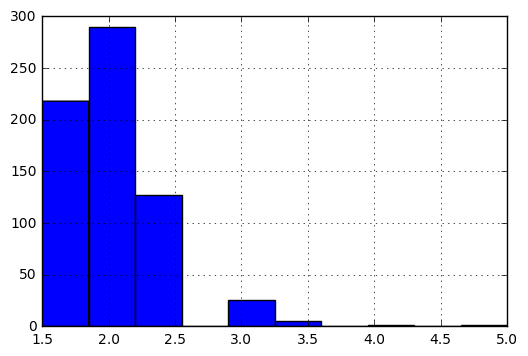

In [42]:
students['Time of stay'].hist()

Most of the student finished their master in 1.5 to 2.5 years, a few in more than that.

In [43]:
students['Time of stay'].describe()

count    668.000000
mean       1.989521
std        0.452258
min        1.500000
25%        1.500000
50%        2.000000
75%        2.000000
max        5.000000
Name: Time of stay, dtype: float64

We have an average of 1.98 years for a master, the minimum is of 1.5 as expected. We have a student that took four years to complete his master, let's look if the data is coherent.

In [44]:
students_1[(students_1['Time of stay']==5)]



,sex,name,sciper,year_master1,specialisation,mineur,year_master2_earliest,year_master2_latest,year_master3,year_pdm,Beginning,Ending,Difference,Time of stay
35,Monsieur,Marx Clément,146742,2008.5,"Signals, Images and Interfaces",NaN,2009.0,2010.0,2012.5,NaN,2008.5,2012.5,4.0,5.0


He seemed to have started his master in September 2008 did two semesters, then stopped start for one semester and did again his second semester in January 2009. Then he stopped for two years and finally did his last semester (master 3) in automn 2012, and we assume that he then directly did his master thesis

### Specialisation data

Let's first keep only student with a specialisation

In [45]:
specialisation=students[~pd.isnull(students['specialisation'])]
specialisation.head(10)


,sex,name,sciper,specialisation,mineur,Beginning,Time of stay
118,Monsieur,Bricola Jean-Charles,180731,"Signals, Images and Interfaces",NaN,2010.5,2.0
403,Monsieur,Campora Simone,180072,Internet computing,NaN,2007.5,2.0
422,Monsieur,Hofer Thomas,165819,Foundations of Software,NaN,2007.5,2.0
440,Monsieur,Muriel Hugo Marcelo,179878,Internet computing,NaN,2007.5,2.0
831,Monsieur,Engilberge Martin Pierre,212790,Internet computing,NaN,2014.5,2.5
837,Monsieur,Gaspoz John,212859,Information Security - SP,NaN,2014.5,2.5
871,Monsieur,Piskas Georgios,244587,Software Systems,NaN,2014.5,2.5
881,Monsieur,Schegg Elias,195675,Internet computing,NaN,2014.5,2.5
886,Monsieur,Valette Laurent Michel,205864,Software Systems,NaN,2014.5,2.5
905,Monsieur,Dosmukhamedov Diyar,192861,Internet computing,NaN,2010.0,2.5


Let's now have a look on students having a specialisation 

,Time of stay
count,112.000000
mean,2.308036
std,0.451452
min,1.500000
25%,2.000000
50%,2.000000
75%,2.500000
max,5.000000


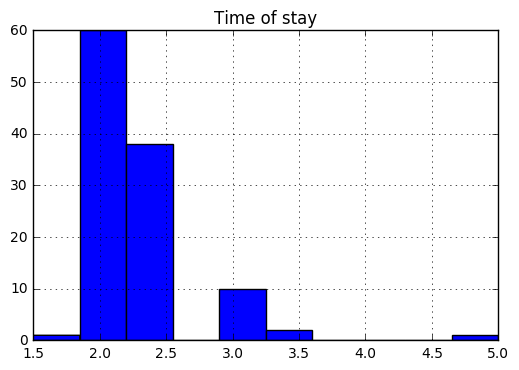

In [46]:
specialisation=specialisation[['specialisation','Time of stay']]

specialisation.hist()
specialisation.describe()




The average stays for people with a specialisation is of 2.308. There is still that one student that did it 5 years. There seem to be one guy that did it 1.5 year. Let's have a look at the data from that student to see if that's possible.

In [47]:
students_1[(students_1['Time of stay']==1.5) & ~pd.isnull(students_1['specialisation'])]



,sex,name,sciper,year_master1,specialisation,mineur,year_master2_earliest,year_master2_latest,year_master3,year_pdm,Beginning,Ending,Difference,Time of stay
912,Monsieur,Steiger Robin,175702,NaN,Foundations of Software,NaN,2010.0,2010.0,2010.5,2011.0,2010.0,2011.0,1.0,1.5


He has been registered in a master thesis so that is a pretty good sign that he finished his master. It is possible that he started his Master in Spring, so is-academia will consider him as master 2 straight away. Then he did master 3. He must have done 90 credits in two semesters which is, I've seen students that did it, possible.

Let's now have a look at specific specialisations.

In [48]:
time_of_stay_avg= specialisation.groupby(['specialisation'])['Time of stay'].mean()


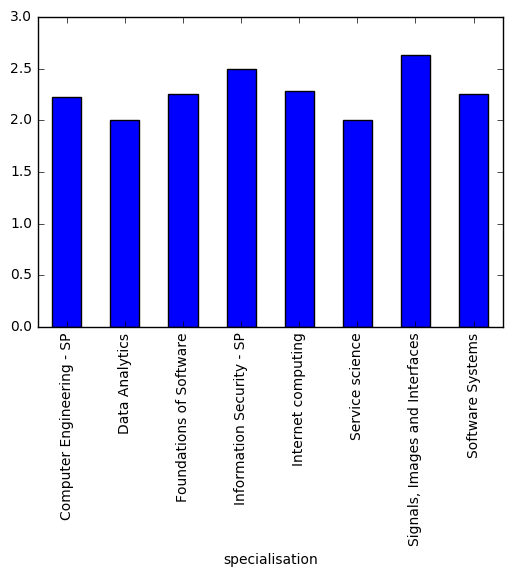

In [49]:
time_of_stay_avg.plot.bar()

Let's now do a welsh test between the average stay for each specialisation and the general average stay.

In [50]:
test = dict()
for n in specialisation['specialisation']:
    spe=specialisation[(specialisation['specialisation']==n)]    
    c=stats.ttest_ind(students['Time of stay'], spe['Time of stay'], equal_var = False)
    test[n]=c
    
    



/Users/Charlotte/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [51]:
test

{'Computer Engineering - SP': Ttest_indResult(statistic=-2.5980698395921573, pvalue=0.029761697611030639),
 'Data Analytics': Ttest_indResult(statistic=nan, pvalue=nan),
 'Foundations of Software': Ttest_indResult(statistic=-4.0784914386525184, pvalue=0.00019932098988213057),
 'Information Security - SP': Ttest_indResult(statistic=nan, pvalue=nan),
 'Internet computing': Ttest_indResult(statistic=-4.6123647150076987, pvalue=3.0858143502299197e-05),
 'Service science': Ttest_indResult(statistic=-0.59885699049194707, pvalue=0.54947157993437734),
 'Signals, Images and Interfaces': Ttest_indResult(statistic=-3.2388574016719063, pvalue=0.0058407301468249078),
 'Software Systems': Ttest_indResult(statistic=-2.3017743423656305, pvalue=0.067150092073042358)}

We can see that there are some specialisation for which the avergae time of stay is significantly different (p-value of 0.5). This is the case for "Foundations of Software", "Internet computing" and "Signal, Images and Interfaces".

The test could not be done for "Data Analytics" and "Information Security - SP" probably because there are not enough data. Let's check for Data Analytics

In [52]:
specialisation[(specialisation['specialisation']=='Data Analytics')].count()



specialisation    1
Time of stay      1
dtype: int64

Yes Indeed, we only have one student registered in Data analytics and this can never be statistically representative